<a href="https://colab.research.google.com/github/danieltoha197/DBSCAN_TA_DANIEL/blob/main/Percobaan_DBSCAN_(Normal_80_%2B_Ringan_20)_dan_(Normal_80_%2B_Berat_20).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Silakan unggah kedua file Excel:
1. Dataset PCA (Normal 80 + Ringan 20).xlsx
2. Dataset PCA (Normal 80 + Berat 20).xlsx
PENTING: Pastikan nama file yang Anda unggah mengandung 'Normal 80 + Ringan 20' dan 'Normal 80 + Berat 20' (case-insensitive).


Saving Dataset PCA (Normal 80 + Berat 20).xlsx to Dataset PCA (Normal 80 + Berat 20) (1).xlsx

--- Mulai proses DBSCAN dan Anomaly Detection untuk file: Normal 80 + Ringan 20 ---
File untuk Normal 80 + Ringan 20 tidak ditemukan di antara file yang diunggah.
Pastikan nama file yang Anda unggah mengandung kata 'Normal 80 + Ringan 20' dan berekstensi .xls atau .xlsx

--- Selesai proses untuk Normal 80 + Ringan 20 ---

--- Mulai proses DBSCAN dan Anomaly Detection untuk file: Normal 80 + Berat 20 ---
DataFrame (beberapa baris pertama):
                     History  Timestamp     X      Y     Z           Source  \
0  [2025-04-27 18:22:20.090]         211 -4.59  -8.71  0.75  Suprax(Normal)   
1  [2025-04-27 18:22:20.144]         338  0.78  -8.79  0.82  Suprax(Normal)   
2  [2025-04-27 18:22:20.251]         441  0.51 -11.65  1.69  Suprax(Normal)   
3  [2025-04-27 18:22:20.356]         544  0.67 -10.98  1.57  Suprax(Normal)   
4  [2025-04-27 18:22:20.463]         647  1.69 -10.67  1.61  Suprax

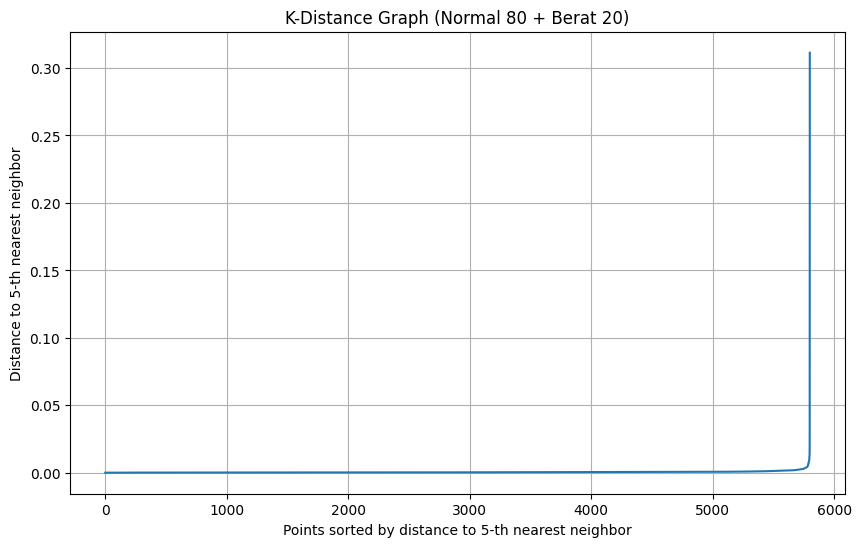

Lihat grafik K-Distance di atas untuk membantu memilih nilai 'eps'.
Gunakan nilai 'min_samples' = 5 untuk DBSCAN.

Menerapkan algoritma DBSCAN pada data...
Menggunakan eps=0.03 dan min_samples=5 untuk DBSCAN.

DataFrame setelah penambahan label cluster DBSCAN (beberapa baris pertama):
                     History  Timestamp     X      Y     Z           Source  \
0  [2025-04-27 18:22:20.090]         211 -4.59  -8.71  0.75  Suprax(Normal)   
1  [2025-04-27 18:22:20.144]         338  0.78  -8.79  0.82  Suprax(Normal)   
2  [2025-04-27 18:22:20.251]         441  0.51 -11.65  1.69  Suprax(Normal)   
3  [2025-04-27 18:22:20.356]         544  0.67 -10.98  1.57  Suprax(Normal)   
4  [2025-04-27 18:22:20.463]         647  1.69 -10.67  1.61  Suprax(Normal)   

   X _normalized  Y _normalized  Z _normalized  PC1_Source  PC2_Source  \
0       0.088240       0.080747       0.494605   -0.002674    0.016784   
1       0.117986       0.080311       0.494827    0.007210   -0.001074   
2       0.116490 

<ipython-input-2-1836893592>:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(len(unique_cluster_labels), 2))


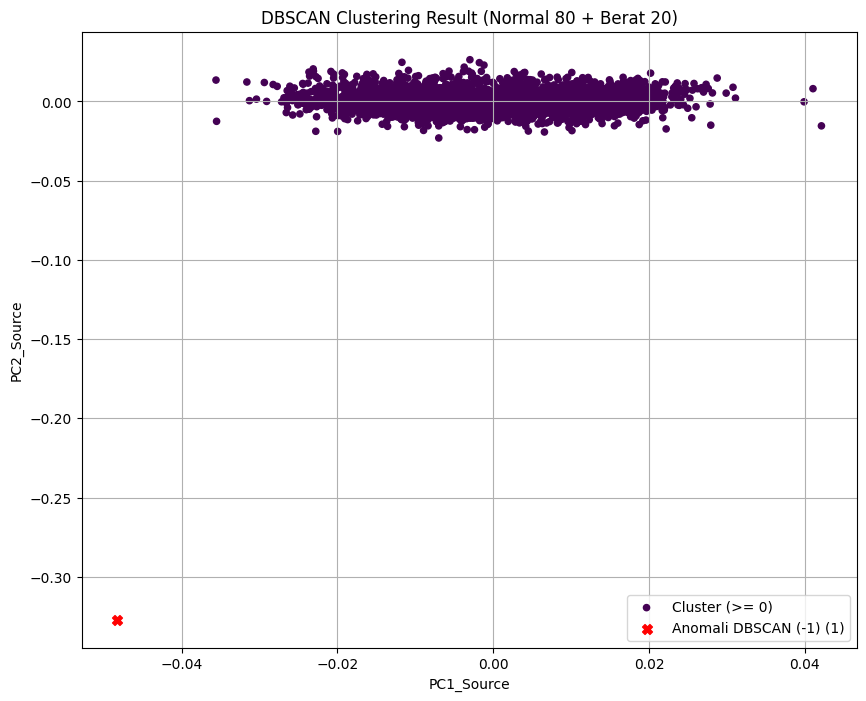


--- Selesai proses untuk Normal 80 + Berat 20 ---


In [ ]:
import pandas as pd
from sklearn.cluster import DBSCAN
import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

# Colab file upload
from google.colab import files

print("Silakan unggah kedua file Excel:")
print("1. Dataset PCA (Normal 80 + Ringan 20).xlsx")
print("2. Dataset PCA (Normal 80 + Berat 20).xlsx")
print("PENTING: Pastikan nama file yang Anda unggah mengandung 'Normal 80 + Ringan 20' dan 'Normal 80 + Berat 20' (case-insensitive).")
uploaded = files.upload()

# --- Fungsi untuk membuat K-distance graph ---
def plot_k_distance(data, k, title):
    if data.empty:
        print(f"Tidak cukup data ({len(data)}) untuk membuat K-distance graph untuk: {title}")
        return
    if k > len(data):
        print(f"Tidak cukup sampel ({len(data)}) untuk membuat K-distance graph dengan k={k} untuk: {title}")
        k = len(data)
    k_actual = max(1, k)
    neigh = NearestNeighbors(n_neighbors=k_actual, algorithm='auto')
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    if distances.shape[1] >= k:
        k_distances = np.sort(distances[:, k - 1], axis=0)
    else:
        print(f"Could not compute {k}-th nearest neighbor distance for {title}. Check data or k value.")
        if k == 1 and distances.shape[1] > 0:
            k_distances = np.sort(distances[:, 0], axis=0)
        else:
            print(f"Not enough neighbors found for k={k}. Skipping K-distance plot for {title}.")
            return
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(k_distances)), k_distances)
    plt.xlabel(f'Points sorted by distance to {k}-th nearest neighbor')
    plt.ylabel(f'Distance to {k}-th nearest neighbor')
    plt.title(f'K-Distance Graph ({title})')
    plt.grid(True)
    plt.show()

# --- Fungsi untuk memplot hasil clustering 2D ---
def plot_2d_clustering(df, x_col, y_col, label_col, title):
    if df.empty:
        print(f"Tidak ada data untuk diplot: {title}")
        return
    if not all(col in df.columns for col in [x_col, y_col, label_col]):
        print(f"Kolom yang dibutuhkan untuk plotting clustering 2D tidak lengkap di DataFrame untuk: {title}")
        print(f"Kolom yang tersedia: {df.columns.tolist()}")
        return
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    anomalies = df[df[label_col] == -1]
    clustered = df[df[label_col] != -1]
    if not clustered.empty:
        unique_cluster_labels = sorted(clustered[label_col].unique())
        cmap = plt.cm.get_cmap('viridis', max(len(unique_cluster_labels), 2))
        colors = [cmap(i) for i in range(len(unique_cluster_labels))]
        label_to_color = dict(zip(unique_cluster_labels, colors))
        c_values = [label_to_color.get(label, 'gray') for label in clustered[label_col]]
        ax.scatter(
            clustered[x_col],
            clustered[y_col],
            c=c_values,
            s=20,
            label='Cluster (>= 0)'
        )
    if not anomalies.empty:
        ax.scatter(
            anomalies[x_col],
            anomalies[y_col],
            c='red',
            s=50,
            marker='X',
            label=f'Anomali DBSCAN (-1) ({len(anomalies)})'
        )
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(title)
    ax.legend()
    plt.grid(True)
    plt.show()

# --- Parameter Global ---
kolom_for_dbscan = ['PC1_Source', 'PC2_Source']
kolom_source = 'Source'
min_samples_value = 5
zscore_threshold = 3
isolation_forest_contamination = 'auto'

# --- Proses untuk kedua dataset ---
datasets = {
    "Normal 80 + Ringan 20": None,
    "Normal 80 + Berat 20": None
}

# Cari file yang sesuai
for name in uploaded.keys():
    lower = name.lower()
    if "normal 80 + ringan 20" in lower:
        datasets["Normal 80 + Ringan 20"] = name
    elif "normal 80 + berat 20" in lower:
        datasets["Normal 80 + Berat 20"] = name

for label, file_name in datasets.items():
    print(f"\n--- Mulai proses DBSCAN dan Anomaly Detection untuk file: {label} ---")
    if file_name is not None:
        try:
            df_pca = pd.read_excel(io.BytesIO(uploaded[file_name]))
            print("DataFrame (beberapa baris pertama):")
            print(df_pca.head())
            print("\nKolom di DataFrame:")
            print(df_pca.columns.tolist())
            required_cols = kolom_for_dbscan + [kolom_source]
            if all(col in df_pca.columns for col in required_cols):
                X_pca = df_pca[kolom_for_dbscan].copy()
                original_rows = len(X_pca)
                X_pca_cleaned = df_pca[kolom_for_dbscan].dropna().copy()
                dropped_indices = df_pca.index.difference(X_pca_cleaned.index)
                df_pca_cleaned = df_pca.drop(dropped_indices).copy()
                dropped_rows = original_rows - len(X_pca_cleaned)
                if dropped_rows > 0:
                    print(f"Peringatan: Menghapus {dropped_rows} baris dengan nilai NaN di kolom yang dipilih untuk deteksi anomali.")
                if not X_pca_cleaned.empty:
                    X_pca = X_pca_cleaned
                    df_pca = df_pca_cleaned
                    total = len(df_pca)
                    print(f"\nMembuat K-distance graph untuk {label} (min_samples={min_samples_value})...")
                    plot_k_distance(X_pca, min_samples_value, label)
                    print(f"Lihat grafik K-Distance di atas untuk membantu memilih nilai 'eps'.")
                    print(f"Gunakan nilai 'min_samples' = {min_samples_value} untuk DBSCAN.")
                    print("\nMenerapkan algoritma DBSCAN pada data...")
                    eps_pca = 0.03 # Silakan sesuaikan berdasarkan K-distance graph
                    print(f"Menggunakan eps={eps_pca} dan min_samples={min_samples_value} untuk DBSCAN.")
                    dbscan_pca = DBSCAN(eps=eps_pca, min_samples=min_samples_value)
                    df_pca['cluster_label_DBSCAN'] = dbscan_pca.fit_predict(X_pca)
                    print("\nDataFrame setelah penambahan label cluster DBSCAN (beberapa baris pertama):")
                    print(df_pca.head())
                    print("\nDistribusi jumlah data per cluster (DBSCAN):")
                    value_counts_dbscan = df_pca['cluster_label_DBSCAN'].value_counts()
                    print(value_counts_dbscan)
                    anomalies_dbscan = value_counts_dbscan.get(-1, 0)
                    normal_dbscan = total - anomalies_dbscan
                    print(f"\nTotal Data: {total}")
                    print(f"Data Anomali/Noise (DBSCAN -1): {anomalies_dbscan}")
                    print(f"Data Normal (DBSCAN): {normal_dbscan}")
                    if anomalies_dbscan > 0:
                        print("\nDistribusi Source untuk Anomali DBSCAN (-1):")
                        anomalies_dbscan_df = df_pca[df_pca['cluster_label_DBSCAN'] == -1]
                        print(anomalies_dbscan_df[kolom_source].value_counts())
                    else:
                        print("\nTidak ada anomali yang terdeteksi oleh DBSCAN untuk dianalisis Sourcenya.")
                    print("\nMenerapkan deteksi anomali menggunakan Z-score pada data...")
                    z_scores_pca = np.abs(zscore(X_pca))
                    df_pca['is_anomaly_zscore'] = (z_scores_pca > zscore_threshold).any(axis=1).astype(int)
                    print("\nDataFrame setelah penambahan label anomali Z-score (beberapa baris pertama):")
                    print(df_pca.head())
                    print(f"\nDistribusi jumlah data per label anomali Z-score (threshold={zscore_threshold}):")
                    value_counts_zscore = df_pca['is_anomaly_zscore'].value_counts()
                    print(value_counts_zscore)
                    anomalies_zscore = value_counts_zscore.get(1, 0)
                    normal_zscore = total - anomalies_zscore
                    print(f"\nData Anomali (Z-score): {anomalies_zscore}")
                    print(f"Data Normal (Z-score): {normal_zscore}")
                    if anomalies_zscore > 0:
                        print("\nDistribusi Source untuk Anomali Z-score:")
                        anomalies_zscore_df = df_pca[df_pca['is_anomaly_zscore'] == 1]
                        print(anomalies_zscore_df[kolom_source].value_counts())
                    else:
                        print("\nTidak ada anomali yang terdeteksi oleh Z-score untuk dianalisis Sourcenya.")
                    print("\nMenerapkan algoritma Isolation Forest pada data...")
                    iso_forest_pca = IsolationForest(contamination=isolation_forest_contamination, random_state=42)
                    df_pca['anomaly_label_isoforest'] = iso_forest_pca.fit_predict(X_pca)
                    print("\nDataFrame setelah penambahan label anomali Isolation Forest (beberapa baris pertama):")
                    print(df_pca.head())
                    print(f"\nDistribusi jumlah data per label anomali Isolation Forest (contamination={isolation_forest_contamination}):")
                    value_counts_isoforest = df_pca['anomaly_label_isoforest'].value_counts()
                    print(value_counts_isoforest)
                    anomalies_isoforest = value_counts_isoforest.get(-1, 0)
                    normal_isoforest = total - anomalies_isoforest
                    print(f"\nData Anomali (Isolation Forest -1): {anomalies_isoforest}")
                    print(f"Data Normal (Isolation Forest): {normal_isoforest}")
                    if anomalies_isoforest > 0:
                        print("\nDistribusi Source untuk Anomali Isolation Forest (-1):")
                        anomalies_isoforest_df = df_pca[df_pca['anomaly_label_isoforest'] == -1]
                        print(anomalies_isoforest_df[kolom_source].value_counts())
                    else:
                        print("\nTidak ada anomali yang terdeteksi oleh Isolation Forest untuk dianalisis Sourcenya.")
                    print("\nMembuat visualisasi clustering DBSCAN dengan highlight anomali DBSCAN...")
                    plot_2d_clustering(
                        df_pca,
                        kolom_for_dbscan[0], kolom_for_dbscan[1],
                        'cluster_label_DBSCAN',
                        f'DBSCAN Clustering Result ({label})'
                    )
                else:
                    print(f"Error: Setelah menghapus baris dengan NaN, tidak ada data yang tersisa di kolom {kolom_for_dbscan}.")
            else:
                print(f"Error: Kolom PCA ({kolom_for_dbscan}) atau kolom Source ({kolom_source}) tidak ditemukan di file {file_name}. Pastikan nama kolom di file Excel sudah benar dan sesuai.")
                print(f"Kolom yang tersedia: {df_pca.columns.tolist()}")
        except Exception as e:
            print(f"Terjadi error saat memproses file {file_name}: {e}")
            import traceback
            print(traceback.format_exc())
            print("Pastikan file yang diunggah adalah file Excel yang benar dan memiliki kolom yang dibutuhkan.")
    else:
        print(f"File untuk {label} tidak ditemukan di antara file yang diunggah.")
        print(f"Pastikan nama file yang Anda unggah mengandung kata '{label}' dan berekstensi .xls atau .xlsx")
    print(f"\n--- Selesai proses untuk {label} ---")